In [ ]:
#!/usr/bin/python
import sys
import numpy as np
from numpy import absolute as abs
from numpy import random as ran
import time
from astropy.io import fits
from scipy.interpolate.interpolate import interp1d
import math
import os.path as ptt
import matplotlib
#matplotlib.use('Agg')
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from progressbar import ProgressBar
from scipy import signal
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d as filt1d
import matplotlib.colors as colors
from IPython.display import Image, display
import warnings
warnings.filterwarnings("ignore")

In [2]:
def conv(xt,ke=2.5):
    nsf=len(xt)
    krn=ke
    xf=filt1d(xt,ke)
    return xf

In [4]:
def oxigen_abun_map(flux_cube,verbose=False):
    Hb=flux_cube[63,:,:]
    Hb[np.where(np.isfinite(Hb) == False)]=0
    EWHb=-flux_cube[639,:,:]
    #print(np.nanmin(EWHb))
    EWHb[np.where(np.isfinite(EWHb) == False)]=0
    #print(np.nanmax(EWHb))
    OIII4959=flux_cube[72,:,:]
    OIII4959[np.where(np.isfinite(OIII4959) == False)]=0
    OIII5007=flux_cube[76,:,:]
    OIII5007[np.where(np.isfinite(OIII5007) == False)]=0
    OII3727=flux_cube[5,:,:]
    OII3727[np.where(np.isfinite(OII3727) == False)]=0
    OIII4363=flux_cube[36,:,:]
    OIII4363[np.where(np.isfinite(OIII4363) == False)]=0
    C1=-0.375
    C2=0.0825
    C3=0.0100
    C4=0.0002
    #OH4363_5007=OIII4363/OIII5007
    P=(OIII4959+OIII5007)/(OII3727+OIII4959+OIII5007)
    R23=(OII3727+OIII4959+OIII5007)/Hb
    R3=(OIII4959+OIII5007)/Hb
    nt=np.where((EWHb <= 1))# | (np.isfinite(EWHb) == False))
    R3[nt]=np.nan
    R23[nt]=np.nan
    P[nt]=np.nan
    nt=np.where(R23 < 0)
    R3[nt]=np.nan
    R23[nt]=np.nan
    P[nt]=np.nan
    nt=np.where(P < 0)
    R3[nt]=np.nan
    R23[nt]=np.nan
    P[nt]=np.nan
    nt=np.where(P > 1)
    R3[nt]=np.nan
    R23[nt]=np.nan
    P[nt]=np.nan
    nt=np.where(R3 < 0)
    R3[nt]=np.nan
    R23[nt]=np.nan
    P[nt]=np.nan
    #logOHp12=6.35+1.45*np.log10(R3)#Equation 4 Pilyugin (2000)
    OHp=C1+C2*R23+C3*P+C4*P*R23#+12+np.log10(R3)
    OH1=(R23+1837.0+2146.0*P+850.0*P**2.0)/(209.5+201.7*P+107.2*P**2.0+4.37*R23)
    OH2=(R23+90.73+94.58*P-5.26*P**2)/(14.81+5.52*P+5.81*P**2.0-0.252*R23)
    nx,ny=Hb.shape
    logOH12=np.zeros([nx,ny])
    logOH12[:,:]=np.nan
    for i in range(0, nx):
        for j in range(0, ny):
            #if logOHp12[i,j] >= 8.25:
            if OH1[i,j] >= 8.55:
                logOH12[i,j]=OH1[i,j]
            #if logOHp12[i,j] <= 8.00:
            if OH2[i,j] <= 8.29:
                logOH12[i,j]=OH2[i,j]
            if (OH2[i,j] > 8.29) and (OH1[i,j] < 8.55) :
                logOH12[i,j]=8.4
            if logOH12[i,j] < 6:
                logOH12[i,j]=6.0
    if verbose:
        print('logR23(min OH), P(min OH), OH1(min OH), OH2(min OH)')
        print(np.log10(R23[np.where(logOH12 == np.nanmin(logOH12))][0]),P[np.where(logOH12 == np.nanmin(logOH12))][0],OH1[np.where(logOH12 == np.nanmin(logOH12))][0],OH2[np.where(logOH12 == np.nanmin(logOH12))][0],"A1")
        print('logR23(max OH), P(max OH), OH1(max OH), OH2(max OH)')
        print(np.log10(R23[np.where(logOH12 == np.nanmax(logOH12))][0]),P[np.where(logOH12 == np.nanmax(logOH12))][0],OH1[np.where(logOH12 == np.nanmax(logOH12))][0],OH2[np.where(logOH12 == np.nanmax(logOH12))][0],"A1")
        print(np.nanmin(OH1),"min OH1")
        print(np.nanmax(OH1),"max OH1")
        print(np.nanmin(logOH12),"min OH")
        print(np.nanmax(logOH12),"max OH")
    return logOH12

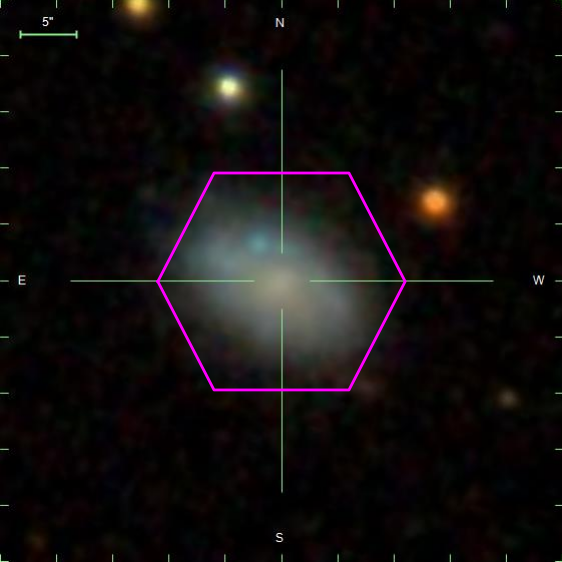

In [5]:
name='manga-11943-3704'
name='manga-11760-6101'
#name='manga-8998-12705'
name='manga-12090-12704'
name='manga-8566-6103'
display(Image(filename='pipe3d/'+name+'.png'))
dir_cube='cubes/'
[cube_data, hdr0]=fits.getdata(dir_cube+name+'.cube.fits.gz', 0, header=True)

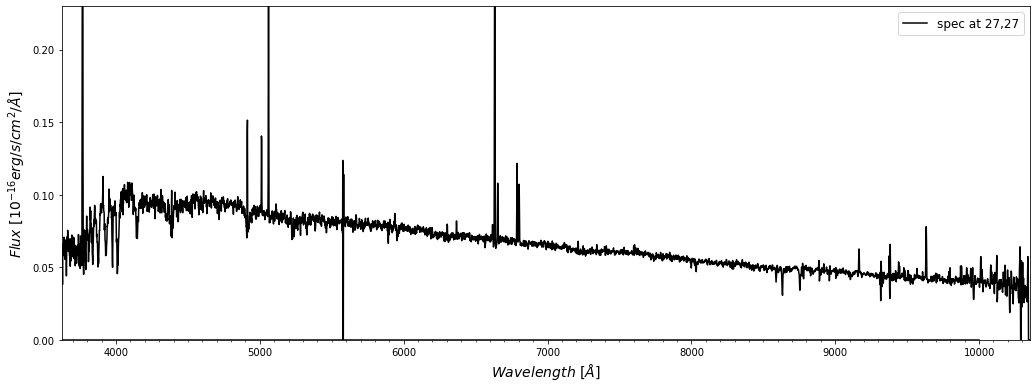

In [6]:
nz,nx,ny=cube_data.shape
crpix=hdr0["CRPIX3"]
try:
    cdelt=hdr0["CD3_3"]
except:
    cdelt=hdr0["CDELT3"]
crval=hdr0["CRVAL3"]
wave=(crval+cdelt*(np.arange(nz)+1-crpix))
i=int(nx/2)
j=int(ny/2)
spec=cube_data[:,i,j]
spec_t=conv(spec,ke=2)
fig, ax = plt.subplots(figsize=(14.5,5.5))
ax.set_ylim(-np.nanmax(spec_t)*0.0,np.nanmax(spec_t))
ax.set_xlim(np.nanmin(wave),np.nanmax(wave))
plt.plot([0,10000],[0,0],linestyle='-',color='black')
plt.plot(wave,spec,linestyle='-',color='black' ,label='spec at '+str(i)+','+str(j),lw=1.5)
ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
plt.legend(loc=1,fontsize=12)
plt.ylabel(r'$Flux\ [10^{-16} erg/s/cm^2/\AA]$',fontsize=14)
plt.xlabel(r'$Wavelength\ [\AA]$',fontsize=14)
fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


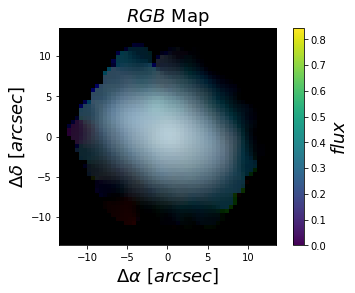

In [46]:
ntB=np.where((wave < 4500) & (wave > 3800))[0]
ntG=np.where((wave < 7000) & (wave > 6500))[0]
ntR=np.where((wave < 10000) & (wave > 9000))[0]
B_m=np.log10(np.nanmean(cube_data[ntB,:,:],axis=0))
G_m=np.log10(np.nanmean(cube_data[ntG,:,:],axis=0))
R_m=np.log10(np.nanmean(cube_data[ntR,:,:],axis=0))
minV=np.log10(0.001)
maxV=np.log10(0.2)
B=(B_m-minV)/(maxV-minV)
G=(G_m-minV)/(maxV-minV)
R=(R_m-minV)/(maxV-minV)
B[np.where(B < 0)]=0
G[np.where(G < 0)]=0
R[np.where(R < 0)]=0
B[np.where(B > 1)]=1
G[np.where(G > 1)]=1
R[np.where(R > 1)]=1

RGB=np.zeros([nx,ny,3])
RGB[:,:,0]=R
RGB[:,:,1]=G
RGB[:,:,2]=B

pix=0.5
tit='flux'
lab=''#[10^{-16}erg/s/cm^2/arcsec^2]'
from matplotlib.colors import LogNorm
plt.title(r'$RGB$ Map',fontsize=18)
plt.xlabel(r'$\Delta \alpha\ [arcsec]$',fontsize=18)
plt.ylabel(r'$\Delta \delta\ [arcsec]$',fontsize=18)#,vmax=vmax,vmin=vmin
ict=plt.imshow(RGB,origin='lower',extent=[-ny*pix/2.,ny*pix/2.,-nx*pix/2.,nx*pix/2.])#,norm=colors.SymLogNorm(10**-1))##,cmap=cm,vmax=vmax,vmin=vmin,norm=colors.SymLogNorm(10**-1))   
plt.xlim(-ny*pix/2,ny*pix/2)
plt.ylim(-nx*pix/2,nx*pix/2)  
cbar=plt.colorbar(ict)#,ticks = tick_list)
cbar.set_label(r"$"+tit+"\ "+lab+"$",fontsize=18)
plt.show()


In [7]:
dir_cube='pipe3d/'
[flux_data, hdr0]=fits.getdata(dir_cube+'flux_elines_long.'+name+'.cube.fits.gz', 0, header=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  del sys.path[0]


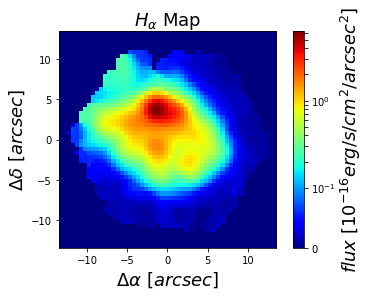

In [8]:
flux=flux_data[124,:,:]
vmax=np.nanmax(flux)
vmin=np.nanmin(flux)
pix=0.5
tit='flux'
lab='[10^{-16}erg/s/cm^2/arcsec^2]'
from matplotlib.colors import LogNorm
nx,ny=flux.shape
cm=plt.cm.get_cmap('jet')
plt.title(r'$H_{\alpha}$ Map',fontsize=18)
plt.xlabel(r'$\Delta \alpha\ [arcsec]$',fontsize=18)
plt.ylabel(r'$\Delta \delta\ [arcsec]$',fontsize=18)#,vmax=vmax,vmin=vmin
ict=plt.imshow(flux,cmap=cm,origin='lower',extent=[-ny*pix/2.,ny*pix/2.,-nx*pix/2.,nx*pix/2.],vmax=vmax,vmin=vmin,norm=colors.SymLogNorm(10**-1))   
plt.xlim(-ny*pix/2,ny*pix/2)
plt.ylim(-nx*pix/2,nx*pix/2)  
cbar=plt.colorbar(ict)#,ticks = tick_list)
cbar.set_label(r"$"+tit+"\ "+lab+"$",fontsize=18)
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  del sys.path[0]


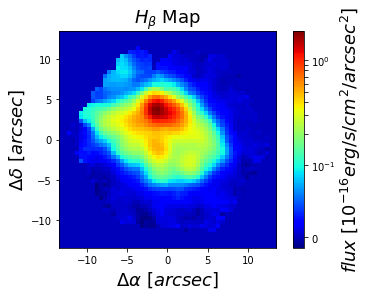

In [9]:
flux=flux_data[63,:,:]
vmax=np.nanmax(flux)
vmin=np.nanmin(flux)
pix=0.5
tit='flux'
lab='[10^{-16}erg/s/cm^2/arcsec^2]'
from matplotlib.colors import LogNorm
nx,ny=flux.shape
cm=plt.cm.get_cmap('jet')
plt.title(r'$H_{\beta}$ Map',fontsize=18)
plt.xlabel(r'$\Delta \alpha\ [arcsec]$',fontsize=18)
plt.ylabel(r'$\Delta \delta\ [arcsec]$',fontsize=18)#,vmax=vmax,vmin=vmin
ict=plt.imshow(flux,cmap=cm,origin='lower',extent=[-ny*pix/2.,ny*pix/2.,-nx*pix/2.,nx*pix/2.],vmax=vmax,vmin=vmin,norm=colors.SymLogNorm(10**-1))   
plt.xlim(-ny*pix/2,ny*pix/2)
plt.ylim(-nx*pix/2,nx*pix/2)  
cbar=plt.colorbar(ict)#,ticks = tick_list)
cbar.set_label(r"$"+tit+"\ "+lab+"$",fontsize=18)
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


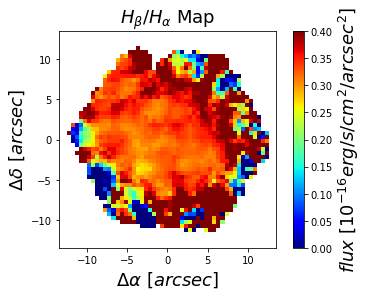

In [50]:
flux=flux_data[63,:,:]/flux_data[124,:,:]
pix=0.5
vmax=0.4
vmin=0
pix=0.5
tit='flux'
lab='[10^{-16}erg/s/cm^2/arcsec^2]'
from matplotlib.colors import LogNorm
nx,ny=flux.shape
cm=plt.cm.get_cmap('jet')
plt.title(r'$H_{\beta}/H_{\alpha}$ Map',fontsize=18)
plt.xlabel(r'$\Delta \alpha\ [arcsec]$',fontsize=18)
plt.ylabel(r'$\Delta \delta\ [arcsec]$',fontsize=18)#,vmax=vmax,vmin=vmin
ict=plt.imshow(flux,cmap=cm,origin='lower',extent=[-ny*pix/2.,ny*pix/2.,-nx*pix/2.,nx*pix/2.],vmax=vmax,vmin=vmin)#,norm=colors.SymLogNorm(10**-1))   
plt.xlim(-ny*pix/2,ny*pix/2)
plt.ylim(-nx*pix/2,nx*pix/2)  
cbar=plt.colorbar(ict)#,ticks = tick_list)
cbar.set_label(r"$"+tit+"\ "+lab+"$",fontsize=18)
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


7.2 8.8


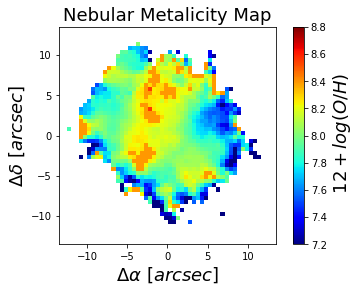

In [10]:
OH=oxigen_abun_map(flux_data,verbose=False)
#OH=flux_data[639,:,:]
vmax=8.8#np.nanmax(OH)
vmin=7.2#np.nanmin(OH)
print(vmin,vmax)
pix=0.5
tit=''
lab='12+log(O/H)'
from matplotlib.colors import LogNorm
nx,ny=OH.shape
cm=plt.cm.get_cmap('jet')
plt.title(r'Nebular Metalicity Map',fontsize=18)
plt.xlabel(r'$\Delta \alpha\ [arcsec]$',fontsize=18)
plt.ylabel(r'$\Delta \delta\ [arcsec]$',fontsize=18)#,vmax=vmax,vmin=vmin
ict=plt.imshow(OH,cmap=cm,origin='lower',extent=[-ny*pix/2.,ny*pix/2.,-nx*pix/2.,nx*pix/2.],vmax=vmax,vmin=vmin)#,norm=colors.SymLogNorm(10**-1))   
plt.xlim(-ny*pix/2,ny*pix/2)
plt.ylim(-nx*pix/2,nx*pix/2)  
cbar=plt.colorbar(ict)#,ticks = tick_list)
cbar.set_label(r"$"+tit+"\ "+lab+"$",fontsize=18)
plt.show()

In [52]:
dir_cube='pipe3d/'
[ssp_data, hdr0]=fits.getdata(dir_cube+name+'.SSP.cube.fits.gz', 0, header=True)

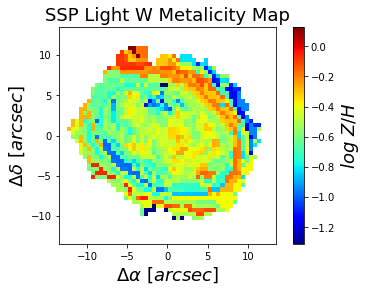

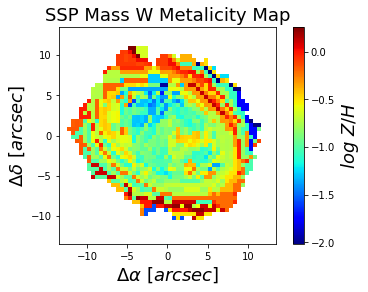

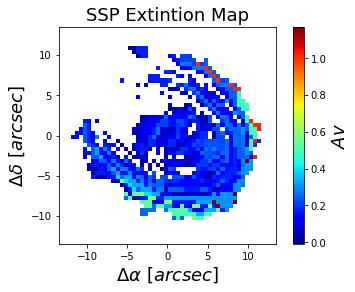

In [53]:
flux=ssp_data[8,:,:]
flux[np.where(flux == 0)]=np.nan
vmax=np.nanmax(flux)
vmin=np.nanmin(flux)
pix=0.5
tit='log\ Z/H'
lab=''
from matplotlib.colors import LogNorm
nx,ny=flux.shape
cm=plt.cm.get_cmap('jet')
plt.title(r'SSP Light W Metalicity Map',fontsize=18)
plt.xlabel(r'$\Delta \alpha\ [arcsec]$',fontsize=18)
plt.ylabel(r'$\Delta \delta\ [arcsec]$',fontsize=18)#,vmax=vmax,vmin=vmin
ict=plt.imshow(flux,cmap=cm,origin='lower',extent=[-ny*pix/2.,ny*pix/2.,-nx*pix/2.,nx*pix/2.],vmax=vmax,vmin=vmin)   
plt.xlim(-ny*pix/2,ny*pix/2)
plt.ylim(-nx*pix/2,nx*pix/2)  
cbar=plt.colorbar(ict)#,ticks = tick_list)
cbar.set_label(r"$"+tit+"\ "+lab+"$",fontsize=18)
plt.show()

flux=ssp_data[9,:,:]
flux[np.where(flux == 0)]=np.nan
vmax=np.nanmax(flux)
vmin=np.nanmin(flux)
pix=0.5
tit='log\ Z/H'
lab=''
from matplotlib.colors import LogNorm
nx,ny=flux.shape
cm=plt.cm.get_cmap('jet')
plt.title(r'SSP Mass W Metalicity Map',fontsize=18)
plt.xlabel(r'$\Delta \alpha\ [arcsec]$',fontsize=18)
plt.ylabel(r'$\Delta \delta\ [arcsec]$',fontsize=18)#,vmax=vmax,vmin=vmin
ict=plt.imshow(flux,cmap=cm,origin='lower',extent=[-ny*pix/2.,ny*pix/2.,-nx*pix/2.,nx*pix/2.],vmax=vmax,vmin=vmin)   
plt.xlim(-ny*pix/2,ny*pix/2)
plt.ylim(-nx*pix/2,nx*pix/2)  
cbar=plt.colorbar(ict)#,ticks = tick_list)
cbar.set_label(r"$"+tit+"\ "+lab+"$",fontsize=18)
plt.show()

flux=ssp_data[11,:,:]
flux[np.where(flux == 0)]=np.nan
vmax=np.nanmax(flux)
vmin=np.nanmin(flux)
pix=0.5
tit='Av'
lab=''
from matplotlib.colors import LogNorm
nx,ny=flux.shape
cm=plt.cm.get_cmap('jet')
plt.title(r'SSP Extintion Map',fontsize=18)
plt.xlabel(r'$\Delta \alpha\ [arcsec]$',fontsize=18)
plt.ylabel(r'$\Delta \delta\ [arcsec]$',fontsize=18)#,vmax=vmax,vmin=vmin
ict=plt.imshow(flux,cmap=cm,origin='lower',extent=[-ny*pix/2.,ny*pix/2.,-nx*pix/2.,nx*pix/2.],vmax=vmax,vmin=vmin)   
plt.xlim(-ny*pix/2,ny*pix/2)
plt.ylim(-nx*pix/2,nx*pix/2)  
cbar=plt.colorbar(ict)#,ticks = tick_list)
cbar.set_label(r"$"+tit+"\ "+lab+"$",fontsize=18)
plt.show()